In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [9]:
import matplotlib.pyplot as plt

# Related plotting
def contourplot(U, X, Y, title=""):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    titles = [r'$\rho$', r'$\rho u$', r'$\rho v$', r'$\rho E$']
    for i in range(4):
        ax = axs[i // 2, i % 2]
        im = ax.imshow(U[:, :, i].T, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(titles[i])
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        fig.colorbar(im, ax=ax, label=titles[i])

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [10]:
def boundary(U):
    #left and right wall
    U[0, :, 1] = 1
    U[-1, :, 1] = U[-2, :, 1]
    U[0, :, 2] = 0
    U[-1, :, 2] = U[-2, :, 2]
    U[0, :, 3] = U[1, :, 3]
    U[-1, :, 3] = U[-2, :, 3]

    #upper and lower wall
    U[:, 0, 1] = U[:, 1, 1]
    U[:, -1, 1] = U[:, -2, 1]
    U[:, 0, 2] = -U[:, 1, 2]
    U[:, -1, 2] = -U[:, -2, 2]
    U[:, 0, 3] = U[:, 1, 3]
    U[:, -1, 3] = U[:, -2, 3]
    return U

import numpy as np

def chorin_projection(u, v, p, dt, dx, dy, rho, nu, NX, NY):
    # Intermediate velocity fields
    u_star = np.zeros_like(u)
    v_star = np.zeros_like(v)
    
    # Step 1: Compute the intermediate velocity fields (u_star, v_star)
    # Neglecting the pressure term for now
    for i in range(1, NX-1):
        for j in range(1, NY-1):
            u_star[i, j] = u[i, j] - dt * (
                (u[i, j] * (u[i+1, j] - u[i-1, j]) / (2 * dx)) +
                (v[i, j] * (u[i, j+1] - u[i, j-1]) / (2 * dy)) +
                nu * ((u[i+1, j] - 2*u[i, j] + u[i-1, j]) / dx**2 +
                      (u[i, j+1] - 2*u[i, j] + u[i, j-1]) / dy**2)
            )
            v_star[i, j] = v[i, j] - dt * (
                (u[i, j] * (v[i+1, j] - v[i-1, j]) / (2 * dx)) +
                (v[i, j] * (v[i, j+1] - v[i, j-1]) / (2 * dy)) +
                nu * ((v[i+1, j] - 2*v[i, j] + v[i-1, j]) / dx**2 +
                      (v[i, j+1] - 2*v[i, j] + v[i, j-1]) / dy**2)
            )

    # Step 2: Solve the Poisson equation for pressure
    for iteration in range(50):  # Iteration count for Poisson solver
        p_new = np.copy(p)
        for i in range(1, NX-1):
            for j in range(1, NY-1):
                p_new[i, j] = ((p[i+1, j] + p_new[i-1, j]) * dy**2 +
                               (p[i, j+1] + p_new[i, j-1]) * dx**2 -
                               rho * (dx**2 * dy**2) / (2 * (dx**2 + dy**2)) * 
                               ((u_star[i+1, j] - u_star[i-1, j]) / (2 * dx) +
                                (v_star[i, j+1] - v_star[i, j-1]) / (2 * dy))) / (2 * (dx**2 + dy**2))
        p = p_new

    # Step 3: Update the velocity fields using the pressure gradient
    for i in range(1, NX-1):
        for j in range(1, NY-1):
            u[i, j] = u_star[i, j] - dt * (p[i+1, j] - p[i-1, j]) / (2 * dx * rho)
            v[i, j] = v_star[i, j] - dt * (p[i, j+1] - p[i, j-1]) / (2 * dy * rho)

    return u, v, p

def update_dt(U, dx, dy, nu, dt):
    """
    Update the time step based on the CFL condition.

    Parameters:
        U: ndarray
            Array representing the state variables (density, u, v, rhoE) with shape (Nx, Ny, 4).
        dx: float
            Spatial step size in the x-direction.
        dy: float
            Spatial step size in the y-direction.
        nu: float
            Viscosity coefficient.
        dt: float
            Time step.

    Returns:
        dt: float
            Updated time step based on the CFL condition.
    """
    max_speed = 0

    # Compute the maximum speed (including velocity and speed of sound)
    for c in range(1, 4):  # Iterate over velocity and total energy components
        speed_c = np.max(np.abs(U[:, :, c] / U[:, :, 0]))  # Compute speed componentwise
        max_speed = max(max_speed, speed_c)

    # Compute the speed of sound
    rho = U[:, :, 0]
    rhoE = U[:, :, 3]
    c_sound = np.sqrt((gamma - 1) * (rhoE / rho))

    # Update time step based on the CFL condition
    dt = min(dx, dy) / (max_speed + np.max(c_sound))

    return dt


In [11]:
# 2d karman vortex

# parameters
gamma = 1.4
L = 2.0

nx = 100
ny = 100

nu = 0.1
dt = 0.001
t_end = 0.5
nt = int(t_end / dt)

dx = 2.0 / (nx - 1)
dy = 2.0 / (ny - 1)

# a cell contains rho, u, v, p

U_init = np.zeros((nx, ny, 4))

#time loop
ts = [0]
U = U_init.copy()
while ts[-1] < t_end:
    # Apply boundary conditions again (if needed)
    U = boundary(U)
    Uold = copy.deepcopy(U)

    """# Update time step
    if ts[-1] < t_end:
        dt = update_dt(U, dx, dy, nu, dt)
    else:
        dt = t_end - ts[-1]"""

    ts.append(ts[-1] + dt)
    
    # Semi-Lagrangian advection
    #U = semi_langrangian_advection_2d(Uold, nu, dt, dx, dy)
    
    # Chorin projection
    U = chorin_projection_2d(Uold, nu, dt, dx, dy)
    

    

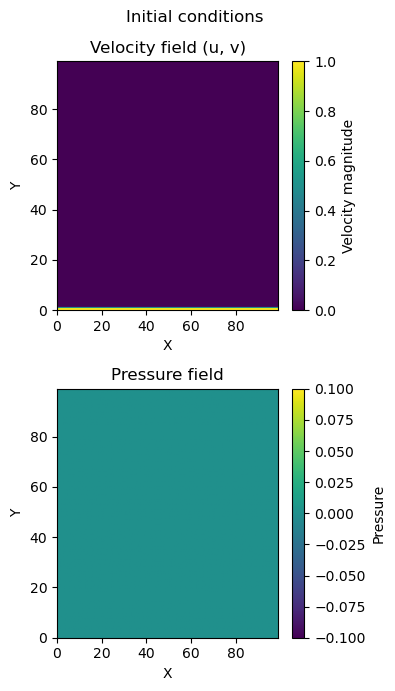

In [56]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags
import matplotlib.pyplot as plt

from numba import jit, prange 
def plot_simulation_results(u, v, p, X, Y, title="Fluid Flow Simulation"):
    fig, axs = plt.subplots(2, 1, figsize=(4, 7))
    titles = ['Velocity field (u, v)', 'Pressure field']
    velocity_magnitude = np.sqrt(u**2 + v**2)

    # Plot velocity field
    ax = axs[0]
    quiver = ax.imshow(velocity_magnitude, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(titles[0])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.colorbar(quiver, ax=ax, label='Velocity magnitude')

    # Plot pressure field
    ax = axs[1]
    im = ax.imshow(p, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(titles[1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    fig.colorbar(im, ax=ax, label='Pressure')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def apply_boundary_conditions(u, v, p):

    # Left and right wall: no-slip condition for u, reflective for v
    u[0, :] = 1  # Left wall: u velocity set to 0 (no-slip)
    u[-1, :] = 0  # Right wall: u velocity set to 0 (no-slip)
    
    v[0, :] = v[1, :]  # Reflective condition for v at the left wall
    v[-1, :] = 0  # Reflective condition for v at the right wall
    
    # Upper and lower wall: reflective for u, no-slip condition for v
    u[:, 0] = -u[:, 1]  # Reflective condition for u at the lower wall
    u[:, -1] = -u[:, -2]  # Reflective condition for u at the upper wall
    
    v[:, 0] = 0  # Lower wall: v velocity set to 0 (no-slip)
    v[:, -1] = 0  # Upper wall: v velocity set to 0 (no-slip)
    
    # Apply boundary conditions to pressure if provided

    p[0, :] = p[1, :]  # Left wall
    p[-1, :] = p[-2, :]  # Right wall
    p[:, 0] = p[:, 1]  # Lower wall
    p[:, -1] = p[:, -2]  # Upper wall
    
    return u, v, p 

@jit(nopython=True)
def semi_lagrangian(u, v, q, dt, dx, dy, sign):
    NX, NY = q.shape
    aux = np.zeros_like(q)
    for i in prange(1, NX - 1):
        for j in range(1, NY - 1):
            sign_u = np.sign(u[i, j]) if sign * u[i, j] > 0 else -np.sign(u[i, j])
            sign_v = np.sign(v[i, j]) if sign * v[i, j] > 0 else -np.sign(v[i, j])
            
            # Manually implementing clipping functionality
            x_back = i - sign_u * u[i, j] * dt / dx
            y_back = j - sign_v * v[i, j] * dt / dy
            
            # Clip i_back and j_back within the grid bounds
            i_back = max(1, min(int(x_back), NX-2))
            j_back = max(1, min(int(y_back), NY-2))
            
            aux[i, j] = q[i_back, j_back]
    return aux

def semi_lagrangian2(u, v, q, dt, dx, dy):
    NX, NY = q.shape
    q0 = np.copy(q)
    q1 = semi_lagrangian(u, v, q0, dt, dx, dy, 1)
    q1 = semi_lagrangian(u, v, q1, dt, dx, dy, -1)
    q1 = q0 + (q0 - q1) / 2.0
    q1 = semi_lagrangian(u, v, q1, dt, dx, dy, 1)
    return q1

@jit(nopython=True, parallel=True)
def get_divergence(u, v, dx, dy, NX, NY):
    # Initialize the divergence field
    divergence = np.zeros((NX-2, NY-2))
    
    # Calculate the divergence of velocity field
    for i in range(1, NX-1):
        for j in range(1, NY-1):
            divergence[i-1, j-1] = (u[i+1, j] - u[i-1, j]) / (2*dx) + (v[i, j+1] - v[i, j-1]) / (2*dy)
    return divergence

def solve_pressure(u, v, dx, dy, NX, NY):
    # Initialize the divergence field
    divergence = get_divergence(u, v, dx, dy, NX, NY)

    # Create the Laplacian operator for the Poisson equation
    num_points = (NX-2) * (NY-2)  # Number of interior points
    main_diagonal = -4 * np.ones(num_points)
    off_diagonal = np.ones(num_points - 1)
    k_diagonal = np.ones(num_points - (NX-2))
    
    # Avoid connecting the end of one row to the beginning of the next
    for i in range(NX-3, num_points - 1, NX-2):
        off_diagonal[i] = 0
    
    diagonals = [main_diagonal, off_diagonal, off_diagonal, k_diagonal, k_diagonal]
    offsets = [0, -1, 1, -(NX-2), NX-2]
    L = diags(diagonals, offsets, shape=(num_points, num_points)).tocsc()
    
    # Solve the Poisson equation
    p_interior_flat = spsolve(L, -divergence.ravel())
    p_interior = p_interior_flat.reshape(NX-2, NY-2)
    
    # Embed the interior solution into a full grid including boundaries
    p = np.zeros((NX, NY))
    p[1:-1, 1:-1] = p_interior
    
    return p



def update_velocity(u, v, p, dt, dx, dy, NX, NY):
    u[1:-1,1:-1] -= dt/dx * (p[2:,1:-1] - p[:-2,1:-1])
    v[1:-1,1:-1] -= dt/dy * (p[1:-1,2:] - p[1:-1,:-2])

# Example parameters and initialization
NX, NY = 100, 100
dx = dy = 1.0
dt = 0.01
u = np.zeros((NX, NY))
v = np.zeros((NX, NY))
p = np.zeros((NX, NY))
u,v,p = apply_boundary_conditions(u, v, p)
plot_simulation_results(u, v, p, np.arange(NX), np.arange(NY), "Initial conditions")
# Main simulation loop (simplified)
for step in range(100):
    # Apply boundary conditions
    u, v, p = apply_boundary_conditions(u, v, p)
    # Semi-Lagrangian advection (for u and v separately, as needed)
    semi_lagrangian2(u, v, v, dt, dx, dy)
    semi_lagrangian2(u, v, u, dt, dx, dy)
    # Solve for pressure
    p = solve_pressure(u, v, dx, dy, NX, NY)
    # Update velocities
    update_velocity(u, v, p, dt, dx, dy, NX, NY)
    # Boundary conditions and other steps (not fully implemented)




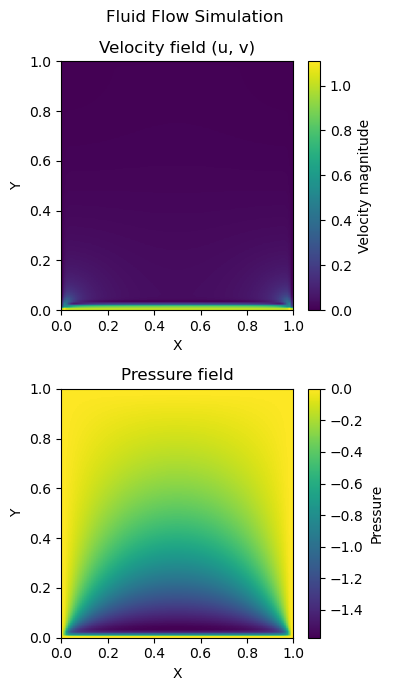

In [57]:
X , Y = np.meshgrid(np.linspace(0, 1, NX), np.linspace(0, 1, NY))

plot_simulation_results(u, v, p, X, Y)

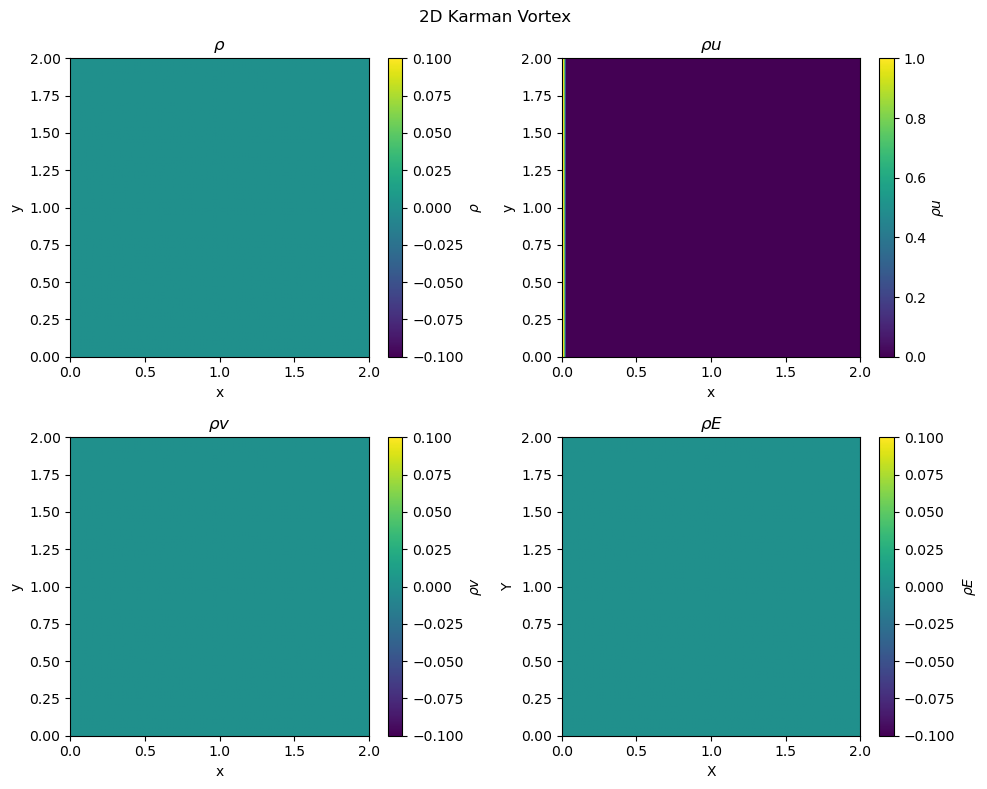

In [12]:
contourplot(U, np.linspace(0, L, nx), np.linspace(0, L, ny), title="2D Karman Vortex")